### 1. Veri Yükleme ve İnceleme
### 2. Ön İşleme
### 3. Özellik Seçimi (Feature Selection)
### 4. Model Kurulumu
### 5. Eğitim (fit)
### 6. Değerlendirme (evaluate + metrics)

In [70]:
pip install pandas scikit-learn seaborn imblearn optuna xgboost boruta

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\user\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [71]:
import pandas as pd

df = pd.read_csv("Human_Resources.csv")
data = df.copy()
data.drop(columns=['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], inplace=True)
print(df['Attrition'].value_counts())

Attrition
No     1233
Yes     237
Name: count, dtype: int64


In [72]:

# Target variable (Yes/No → 1/0)
from sklearn.calibration import LabelEncoder

data["Attrition"] = data["Attrition"].map({"Yes": 1, "No": 0})

# Encode the categorical columns
categorical_cols = data.select_dtypes(include="object").columns
le = LabelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col]) # For example : gender "male" -> 1 , gender "female" -> 0

# Split x and y 
X = data.drop("Attrition", axis=1)
y = data["Attrition"]


In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Random Forest for Attribute Selection
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Take meaningful features
sfm = SelectFromModel(model, prefit=True)
X_values = sfm.transform(X) # Column Numerical Values 2 dimentional array [[1,2,3...],[4,5,6...]...]
selected_columns = X.columns[sfm.get_support()] # Column names


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [74]:
print("Most meaningful features:")
for feature in selected_columns:
    print("•", feature)

Most meaningful features:
• Age
• DailyRate
• DistanceFromHome
• HourlyRate
• MonthlyIncome
• MonthlyRate
• NumCompaniesWorked
• OverTime
• PercentSalaryHike
• TotalWorkingYears
• YearsAtCompany
• YearsWithCurrManager


In [75]:
from imblearn.over_sampling import SMOTE

# SMOTE uygulaması
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_values, y)

print("Orijinal:", X_values.shape, y.shape)
print("SMOTE sonrası:", X_resampled.shape, y_resampled.shape)

Orijinal: (1470, 12) (1470,)
SMOTE sonrası: (2466, 12) (2466,)


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
import optuna
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

def objective(trial):
    # Hiperparametre aralıkları
    n_layers = trial.suggest_int("n_layers", 1, 3)
    units = trial.suggest_int("units", 16, 128)
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])

    # Modeli oluştur
    model = Sequential()
    model.add(Dense(units, input_dim=X_train_scaled.shape[1], activation=activation))
    model.add(Dropout(dropout_rate))

    for _ in range(n_layers - 1):
        model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(X_train_scaled, y_train,
              validation_split=0.2,
              epochs=100,
              batch_size=trial.suggest_categorical("batch_size", [16, 32, 64]),
              callbacks=[early_stop],
              verbose=0)

    y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
    acc = accuracy_score(y_test, y_pred)

    return acc

In [78]:
""" study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
                                THIS IS FOR HYPERTUNING
print("En iyi parametreler:")
print(study.best_params) """

' study = optuna.create_study(direction="maximize")\nstudy.optimize(objective, n_trials=20)\n                                THIS IS FOR HYPERTUNING\nprint("En iyi parametreler:")\nprint(study.best_params) '

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

# ANN mode
ann_model = Sequential()
ann_model.add(Dense(88, input_dim=X_train_scaled.shape[1], activation='relu'))
ann_model.add(Dropout(0.41))
ann_model.add(Dense(88, activation='relu'))
ann_model.add(Dropout(0.41))
ann_model.add(Dense(88, activation='relu'))
ann_model.add(Dropout(0.41))
ann_model.add(Dense(1, activation='sigmoid'))

ann_model.compile(optimizer=Adam(learning_rate=0.0015), # adam is popular learning algorithm
              loss='binary_crossentropy', # binary_crossentropy is a loss function for 1 or 0 values
              metrics=['accuracy'])
                                                    

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [81]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',       # or 'val_accuracy' -> check the value for early stopping
    patience=5,               # how many epochs to wait until no increase in the performance
    restore_best_weights=True 
)

# Train
history = ann_model.fit(
    X_train_scaled, y_train, 
    epochs=100, 
    batch_size=16, 
    validation_split=0.2, 
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)

# Evaluate
test_loss, test_acc = ann_model.evaluate(X_test_scaled, y_test)
print("Test Doğruluğu:", test_acc)
print("Seçilen Özellikler:", selected_columns.tolist())

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5680 - loss: 0.6787 - val_accuracy: 0.6203 - val_loss: 0.6338
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6436 - loss: 0.6305 - val_accuracy: 0.6152 - val_loss: 0.6201
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6738 - loss: 0.6026 - val_accuracy: 0.6278 - val_loss: 0.6094
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6762 - loss: 0.5822 - val_accuracy: 0.6304 - val_loss: 0.6028
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7043 - loss: 0.5720 - val_accuracy: 0.6557 - val_loss: 0.6089
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7061 - loss: 0.5568 - val_accuracy: 0.6709 - val_loss: 0.5933
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7002 - loss: 0.5689 - val_accuracy: 0.6582 - val_loss: 0.5992
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7245 - loss: 0.5536 - val_accuracy: 0.6886 - v

In [82]:
# RF modelini ANN ile aynı X_train verisi ile eğit
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [83]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [12:58:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [84]:
# RF tahminini ANN ile aynı X_test üzerinde al
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# ANN tahminleri
ann_probs = ann_model.predict(X_test_scaled).flatten()

""" xgb_probs = xgb_model.predict_proba(X_test)[:, 1] """

# Ensemble: ortalama

ensemble_probs = (ann_probs + rf_probs) / 2  
y_pred_ensemble = (ensemble_probs > 0.5).astype(int)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


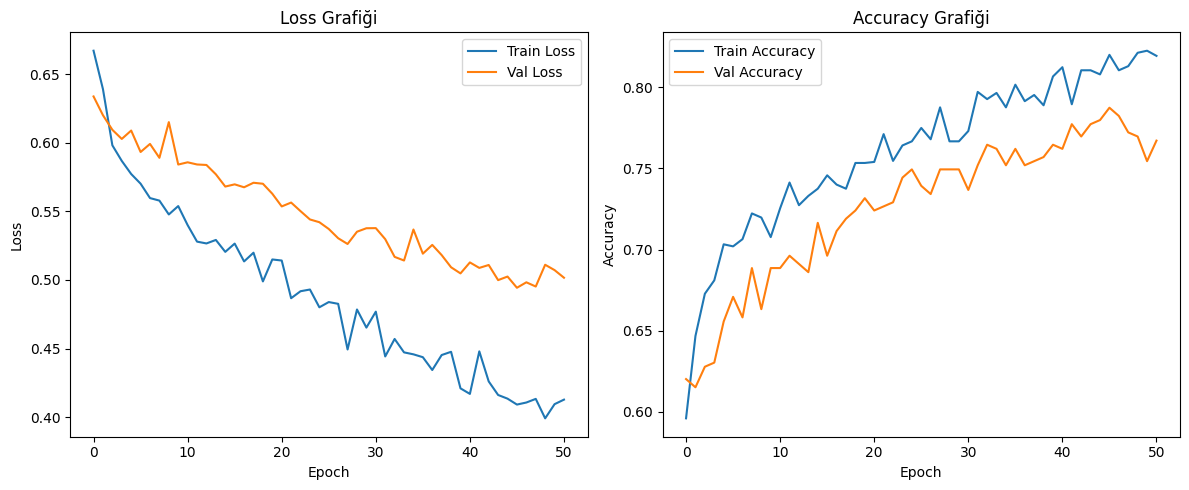

In [85]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Loss (kayıp) grafiği
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Grafiği')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy (doğruluk) grafiği
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Grafiği')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

              precision    recall  f1-score   support

           0       0.87      0.80      0.84       250
           1       0.81      0.88      0.85       244

    accuracy                           0.84       494
   macro avg       0.84      0.84      0.84       494
weighted avg       0.84      0.84      0.84       494



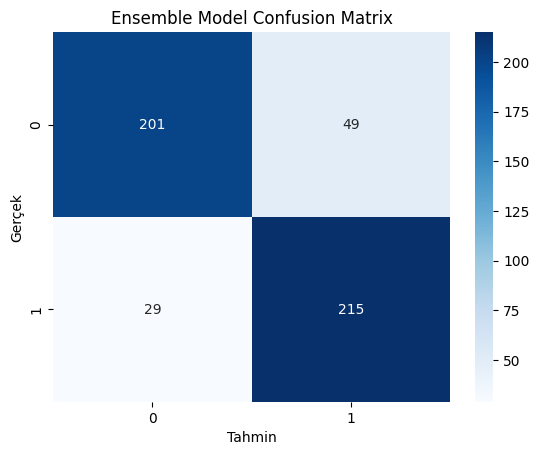

In [86]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred_ensemble))

cm = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Ensemble Model Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()